In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

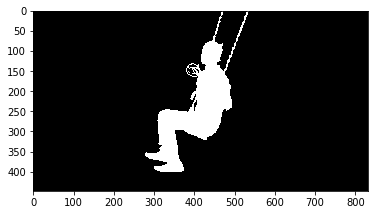

In [3]:
gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/swing/00043.png")[16:-16, 11:-11]
plt.imshow(gt, cmap='gray')

In [4]:
flow = np.zeros((448, 832, 2))

In [5]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [6]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [7]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00043.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00044.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [8]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

In [9]:
lambdaTensor = tf.placeholder(tf.float32)
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)

tLoss = pLoss + lambdaTensor * sLoss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
sGrad = tf.gradients(sLoss, flow)
pGrad = tf.gradients(pLoss, flow)
tGrad = tf.gradients(tLoss, flow)

In [11]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [12]:
itr = 9000
solver, solver_op, learningRateTensor = attach_ADAM_Solver(tLoss)

In [17]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
sGrads = []
pGrads = []
tGrads = []
flows = []
start_time = None
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            lambdaTensor: 2e4
        }
        _, p, s, f, sg = sess.run([solver_op, pLoss, sLoss, flow, sGrad], feed_dict = feed_dict)
        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

1
Photo loss: 4162.661621
Smooth loss: 0.000004
11
Photo loss: 3784.786377
Smooth loss: 0.954696
21
Photo loss: 3604.541260
Smooth loss: 0.296749
31
Photo loss: 3550.106689
Smooth loss: 0.112178
41
Photo loss: 3494.647949
Smooth loss: 0.049642
51
Photo loss: 3441.701660
Smooth loss: 0.025815
61
Photo loss: 3399.769531
Smooth loss: 0.017236
71
Photo loss: 3365.355713
Smooth loss: 0.014311
81
Photo loss: 3336.695801
Smooth loss: 0.013430
91
Photo loss: 3311.305176
Smooth loss: 0.013313
101
Photo loss: 3288.755615
Smooth loss: 0.013433
111
Photo loss: 3265.263672
Smooth loss: 0.013710
121
Photo loss: 3242.244141
Smooth loss: 0.014057
131
Photo loss: 3220.715088
Smooth loss: 0.014374
141
Photo loss: 3200.401367
Smooth loss: 0.014696
151
Photo loss: 3180.300781
Smooth loss: 0.014983
161
Photo loss: 3160.739258
Smooth loss: 0.015255
171
Photo loss: 3141.632568
Smooth loss: 0.015513
181
Photo loss: 3123.284424
Smooth loss: 0.015748
191
Photo loss: 3104.311768
Smooth loss: 0.015968
201
Photo l

1641
Photo loss: 1148.060669
Smooth loss: 0.032822
1651
Photo loss: 1144.052734
Smooth loss: 0.032761
1661
Photo loss: 1140.230103
Smooth loss: 0.031971
1671
Photo loss: 1136.405029
Smooth loss: 0.031323
1681
Photo loss: 1132.836670
Smooth loss: 0.030963
1691
Photo loss: 1129.537231
Smooth loss: 0.032052
1701
Photo loss: 1126.397949
Smooth loss: 0.032039
1711
Photo loss: 1123.206421
Smooth loss: 0.032223
1721
Photo loss: 1120.139648
Smooth loss: 0.032369
1731
Photo loss: 1117.195801
Smooth loss: 0.031443
1741
Photo loss: 1114.151123
Smooth loss: 0.031438
1751
Photo loss: 1111.647461
Smooth loss: 0.031622
1761
Photo loss: 1108.786743
Smooth loss: 0.032308
1771
Photo loss: 1105.820801
Smooth loss: 0.031956
1781
Photo loss: 1102.771973
Smooth loss: 0.031743
1791
Photo loss: 1099.897705
Smooth loss: 0.031922
1801
Photo loss: 1096.993164
Smooth loss: 0.032351
1811
Photo loss: 1094.041016
Smooth loss: 0.032172
1821
Photo loss: 1091.095825
Smooth loss: 0.031802
1831
Photo loss: 1087.730713
Sm

3281
Photo loss: 795.261841
Smooth loss: 0.034491
3291
Photo loss: 793.586548
Smooth loss: 0.034466
3301
Photo loss: 791.901794
Smooth loss: 0.034919
3311
Photo loss: 790.618042
Smooth loss: 0.035274
3321
Photo loss: 789.182068
Smooth loss: 0.034808
3331
Photo loss: 787.589539
Smooth loss: 0.034595
3341
Photo loss: 786.164490
Smooth loss: 0.034323
3351
Photo loss: 784.836853
Smooth loss: 0.034415
3361
Photo loss: 783.686584
Smooth loss: 0.035703
3371
Photo loss: 782.473145
Smooth loss: 0.035392
3381
Photo loss: 781.238220
Smooth loss: 0.033923
3391
Photo loss: 780.255005
Smooth loss: 0.034407
3401
Photo loss: 779.071533
Smooth loss: 0.034866
3411
Photo loss: 778.017883
Smooth loss: 0.035250
3421
Photo loss: 777.123535
Smooth loss: 0.035632
3431
Photo loss: 776.118835
Smooth loss: 0.035715
3441
Photo loss: 775.187866
Smooth loss: 0.035372
3451
Photo loss: 774.063110
Smooth loss: 0.034187
3461
Photo loss: 773.267761
Smooth loss: 0.034283
3471
Photo loss: 772.165710
Smooth loss: 0.034837


KeyboardInterrupt: 

In [17]:
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
tLosses = pLosses + 1000 * sLosses

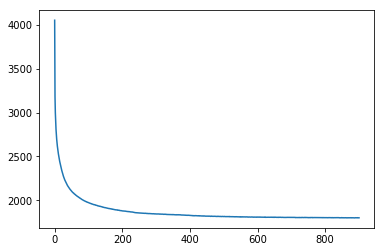

In [18]:
plt.plot(tLosses)

In [19]:
# np.save("swing_sgd_lambda10k", tLosses)
# np.save("swing_adam_lambda10k", tLosses)
np.save("swing_sgd_lambda1k", tLosses)
# np.save("swing_adam_lambda1k", tLosses)